# Full credit of this kernel goes to kmader on Kaggle. I simply forked it for educational purposes.

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = os.path.join('..', 'input')
stage_label = 'stage1'

In [2]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir, '{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
26966,e7a3a7c99483c243742b6cfa74e81cd48f126dcef00401...,"[193458, 9, 193974, 17, 194493, 19, 195011, 23..."
19882,a7f6194ddbeaefb1da571226a97785d09ccafc5893ce3c...,"[8449, 2, 8705, 3, 8961, 4, 9217, 5, 9473, 7, ..."
25607,dad607a203483439fcbc2acecd0a39fb5e5a94a32a9434...,"[6023, 6, 6278, 8, 6533, 9, 6789, 10, 7045, 10..."


In [3]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
9183,../input/stage1_train/c304a1fdf3bca2f4b4580d2c...,c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf...,masks,train,stage1
11199,../input/stage1_train/c3bec1066aae20f48b82975e...,c3bec1066aae20f48b82975e7e8b684cd67635a8baf211...,masks,train,stage1


In [4]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0

train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x:x.astype(int))
train_img_df.sample(1)

CPU times: user 24.1 s, sys: 2.82 s, total: 26.9 s
Wall time: 29.4 s


# Show a few images 

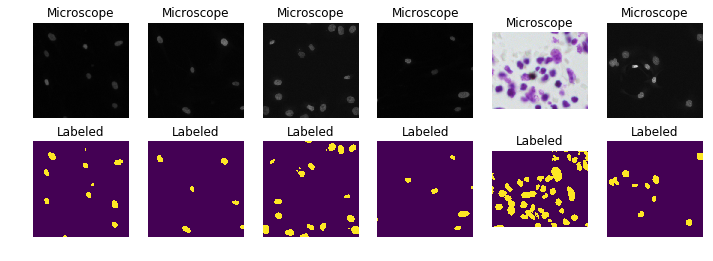

In [5]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

# Intensity Distribution

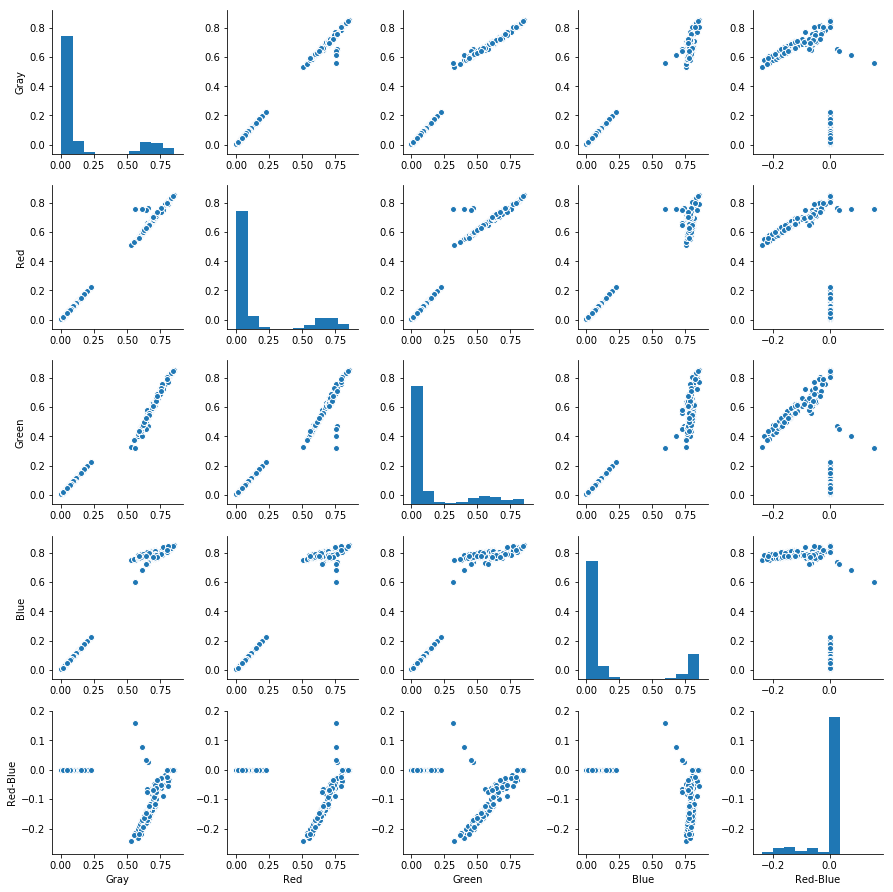

In [6]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean([x[:, :, 1]]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean([x[:, :, 2]]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Red-Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:, :, 0]-x[:, :, 2]))
sns.pairplot(train_img_df[['Gray','Red', 'Green', 'Blue', 'Red-Blue']])

# Check Dimension
Show the dimensions of the data to see the variety in the input images

In [7]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

# CNN

In [8]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS), name= 'NormalizeInput'))

simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))

simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

simple_cnn.add(Conv2D(16, kernel_size = (1, 1), padding = 'same'))
simple_cnn.add(Conv2D(1, kernel_size = (1, 1), padding = 'same', activation = 'sigmoid'))

simple_cnn.summary()


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 16)    528       
__________

# Loss

In [9]:
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

simple_cnn.compile(optimizer = 'adam', 
                  loss= dice_coef_loss,
                  metrics = [dice_coef, 'acc', 'mse'])


# Simple Training

In [10]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'], 0), np.expand_dims(np.expand_dims(c_row['masks'], -1), 0)
            
simple_cnn.fit_generator(simple_gen(), steps_per_epoch=train_img_df.shape[0],
                        epochs = 3)

Epoch 1/3
670/670 [==============================] - 14s 21ms/step - loss: -0.7218 - dice_coef: 0.7218 - acc: 0.8951 - mean_squared_error: 0.0985
Epoch 2/3
670/670 [==============================] - 10s 15ms/step - loss: -0.8000 - dice_coef: 0.8000 - acc: 0.9304 - mean_squared_error: 0.0675
Epoch 3/3
670/670 [==============================] - 10s 15ms/step - loss: -0.8013 - dice_coef: 0.8013 - acc: 0.9300 - mean_squared_error: 0.0684


# Apply to Test

In [11]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:, :, :IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
CPU times: user 432 ms, sys: 46.5 ms, total: 478 ms
Wall time: 482 ms


In [12]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

CPU times: user 650 ms, sys: 82.3 ms, total: 732 ms
Wall time: 681 ms


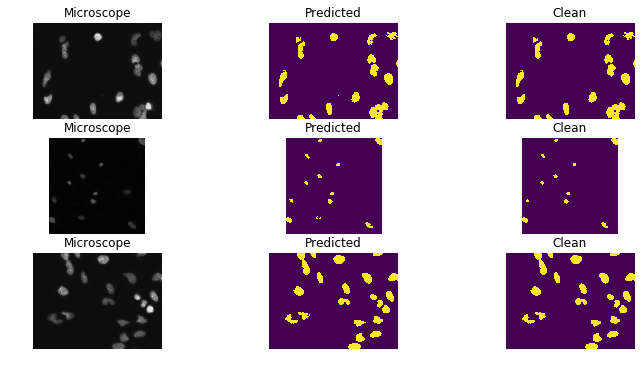

In [14]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), m_axs):
    
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

# RLE (Run Length Encoding)

In [18]:
from skimage.morphology import label
def rle_encoding(x):
    '''
    x: numpy array of shape height, width, 1-mask, 0-background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
        return run_lengths
    
def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0, 0] = 1
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [25]:
_, train_rle_row = next(train_img_df.tail(5).iterrows())
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

In [26]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']

In [29]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]),
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else: 
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

Matches: 14, Mismatches: 12, Accuracy 53.8%


# Calculate RLE forall masks

In [30]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [32]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list +=[dict(ImageId=c_row['ImageId'],
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

1697 regions found for 65 images


,EncodedPixels,ImageId
1467,121677 1,d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633f...
1341,159210 1,d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633f...
832,53168 1,699f2992cd71e2e28cf45f81347ff22e76b37541ce8808...


In [33]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('../submissions/simple.csv', index = False)